#Library

In [1]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

In [2]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import matplotlib.pyplot as plt

In [3]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Data Preparation

In [7]:
!unzip "/content/Indonesian Food.zip" -d "/content/dataset"

Archive:  /content/Indonesian Food.zip
  inflating: /content/dataset/README.roboflow.txt  
   creating: /content/dataset/test/
   creating: /content/dataset/test/01. Ayam Betutu/
 extracting: /content/dataset/test/01. Ayam Betutu/Ayam-Betutu-10_jpg.rf.5d86db81a6776e82141fb3ee871765f8.jpg  
 extracting: /content/dataset/test/01. Ayam Betutu/Ayam-Betutu-15_jpg.rf.fef967f1f4840b854194cf06583cfda7.jpg  
 extracting: /content/dataset/test/01. Ayam Betutu/Ayam-Betutu-30_jpg.rf.ab70ab41517e8b50800ab03ae13b5ca6.jpg  
 extracting: /content/dataset/test/01. Ayam Betutu/Ayam-Betutu-32_jpg.rf.936f7e4f15ead5fd837e201998f21bac.jpg  
 extracting: /content/dataset/test/01. Ayam Betutu/Ayam-Betutu-34_jpg.rf.17b81d2b41590ed27364fbdd1b125927.jpg  
 extracting: /content/dataset/test/01. Ayam Betutu/Ayam-Betutu-41_jpg.rf.8494c0dbf8507e5fcd7dcf0e3ab20d9a.jpg  
 extracting: /content/dataset/test/01. Ayam Betutu/Ayam-Betutu-55_jpg.rf.d882d30ac3b5c6c301e52b9829d468be.jpg  
 extracting: /content/dataset/test/01

In [8]:
base_dir = "/content/dataset"

# menampilkan jumlah kelas dan gambar per kelas
def count_classes_and_images(folder_name):
    folder_path = os.path.join(base_dir, folder_name)
    class_names = sorted(os.listdir(folder_path))

    total_images = 0

    print(f"\nFolder: {folder_name}")
    print(f"Jumlah kelas: {len(class_names)}")

    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        num_images = len(os.listdir(class_path))
        total_images += num_images
        print(f" - Kelas '{class_name}': {num_images} gambar")

    print(f"\nTotal seluruh gambar di folder '{folder_name}': {total_images} gambar")

count_classes_and_images("test")
count_classes_and_images("train")
count_classes_and_images("valid")


Folder: test
Jumlah kelas: 18
 - Kelas '01. Ayam Betutu': 8 gambar
 - Kelas '02. Beberuk Terong': 4 gambar
 - Kelas '03. Coto Makassar': 3 gambar
 - Kelas '04. Gudeg': 5 gambar
 - Kelas '05. Kerak Telor': 3 gambar
 - Kelas '06. Mie Aceh': 4 gambar
 - Kelas '07. Nasi Kuning': 4 gambar
 - Kelas '08. Nasi Pecel': 7 gambar
 - Kelas '09. Papeda': 3 gambar
 - Kelas '10. Pempek': 4 gambar
 - Kelas '11. Peuyeum': 2 gambar
 - Kelas '12. Rawon': 5 gambar
 - Kelas '13. Rendang': 9 gambar
 - Kelas '14. Sate Madura': 9 gambar
 - Kelas '15. Serabi': 7 gambar
 - Kelas '16. Soto Banjar': 3 gambar
 - Kelas '17. Soto Lamongan': 6 gambar
 - Kelas '18. Tahu Sumedang': 3 gambar

Total seluruh gambar di folder 'test': 89 gambar

Folder: train
Jumlah kelas: 18
 - Kelas '01. Ayam Betutu': 111 gambar
 - Kelas '02. Beberuk Terong': 78 gambar
 - Kelas '03. Coto Makassar': 105 gambar
 - Kelas '04. Gudeg': 117 gambar
 - Kelas '05. Kerak Telor': 108 gambar
 - Kelas '06. Mie Aceh': 84 gambar
 - Kelas '07. Nasi Kuni

#Plot Distribusi

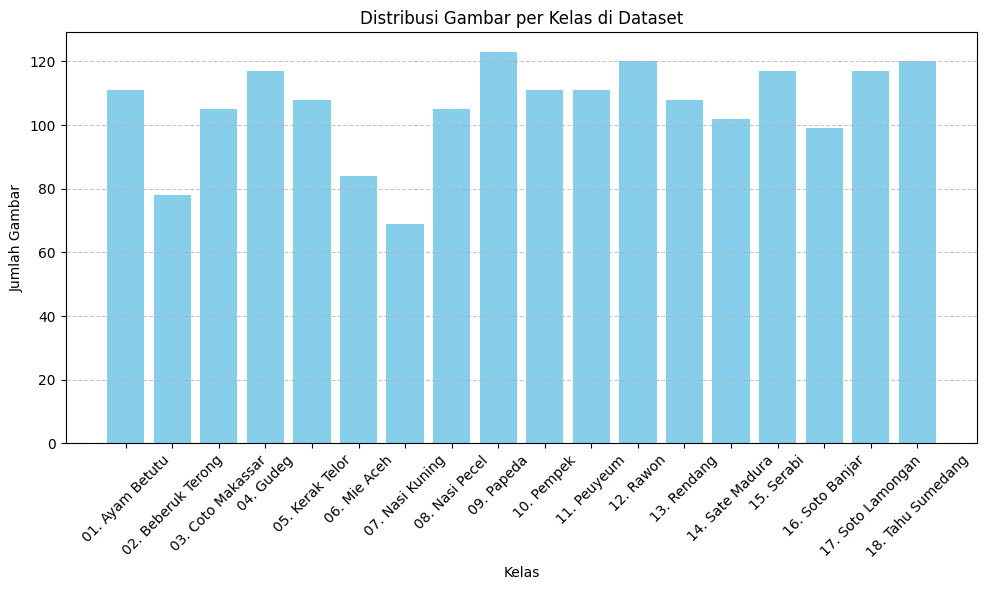

In [9]:
combined_dir = "/content/dataset/train"

class_names = sorted(os.listdir(combined_dir))
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(combined_dir, class_name)
    num_images = len(os.listdir(class_path))
    class_counts[class_name] = num_images

# Plot distribusi
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Distribusi Gambar per Kelas di Dataset")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
dir = "dataset"

# menampilkan jumlah kelas dan gambar per kelas
def count_classes_and_images(folder_name):
    folder_path = os.path.join(dir, folder_name)
    class_names = sorted(os.listdir(folder_path))

    total_images = 0

    print(f"\nFolder: {folder_name}")
    print(f"Jumlah kelas: {len(class_names)}")

    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        num_images = len(os.listdir(class_path))
        total_images += num_images
        print(f" - Kelas '{class_name}': {num_images} gambar")

    print(f"\nTotal seluruh gambar di folder '{folder_name}': {total_images} gambar")

count_classes_and_images("train")


Folder: train
Jumlah kelas: 18
 - Kelas '01. Ayam Betutu': 111 gambar
 - Kelas '02. Beberuk Terong': 78 gambar
 - Kelas '03. Coto Makassar': 105 gambar
 - Kelas '04. Gudeg': 117 gambar
 - Kelas '05. Kerak Telor': 108 gambar
 - Kelas '06. Mie Aceh': 84 gambar
 - Kelas '07. Nasi Kuning': 69 gambar
 - Kelas '08. Nasi Pecel': 105 gambar
 - Kelas '09. Papeda': 123 gambar
 - Kelas '10. Pempek': 111 gambar
 - Kelas '11. Peuyeum': 111 gambar
 - Kelas '12. Rawon': 120 gambar
 - Kelas '13. Rendang': 108 gambar
 - Kelas '14. Sate Madura': 102 gambar
 - Kelas '15. Serabi': 117 gambar
 - Kelas '16. Soto Banjar': 99 gambar
 - Kelas '17. Soto Lamongan': 117 gambar
 - Kelas '18. Tahu Sumedang': 120 gambar

Total seluruh gambar di folder 'train': 1905 gambar


# Data Splitting

# Preprocessing dan Load

In [11]:
batch_size = 32

train_dir = "/content/dataset/train"
val_dir = "/content/dataset/valid"
test_dir = "/content/dataset/test"

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1905 images belonging to 18 classes.
Found 179 images belonging to 18 classes.
Found 89 images belonging to 18 classes.


# Model Transfer Learning

In [19]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model_3 = Model(inputs=base_model.input, outputs=output)
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training dan Evaluasi Model

In [20]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    directory='/content/dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Validasi biasanya tanpa augmentasi

val_generator = val_datagen.flow_from_directory(
    directory='/content/dataset/valid',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# Training model
history = model_3.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[reduce_lr]
)

Found 1905 images belonging to 18 classes.
Found 179 images belonging to 18 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 177ms/step - accuracy: 0.2363 - loss: 2.5897 - val_accuracy: 0.6872 - val_loss: 1.0978 - learning_rate: 0.0010
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.6807 - loss: 1.0460 - val_accuracy: 0.8101 - val_loss: 0.6917 - learning_rate: 0.0010
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.7867 - loss: 0.6925 - val_accuracy: 0.8547 - val_loss: 0.5380 - learning_rate: 0.0010
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8297 - loss: 0.5386 - val_accuracy: 0.8715 - val_loss: 0.5268 - learning_rate: 0.0010
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.8895 - loss: 0.3957 - val_accuracy: 0.8883 - val_loss: 0.4393 - learning_rate: 0.0010
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.8918 - loss: 0.3569 - val_accuracy: 0.8771 - val_loss: 0.4777 - learning_rate: 0.0010
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9363 - loss: 0.2372 - val_a

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9199 - loss: 0.2586


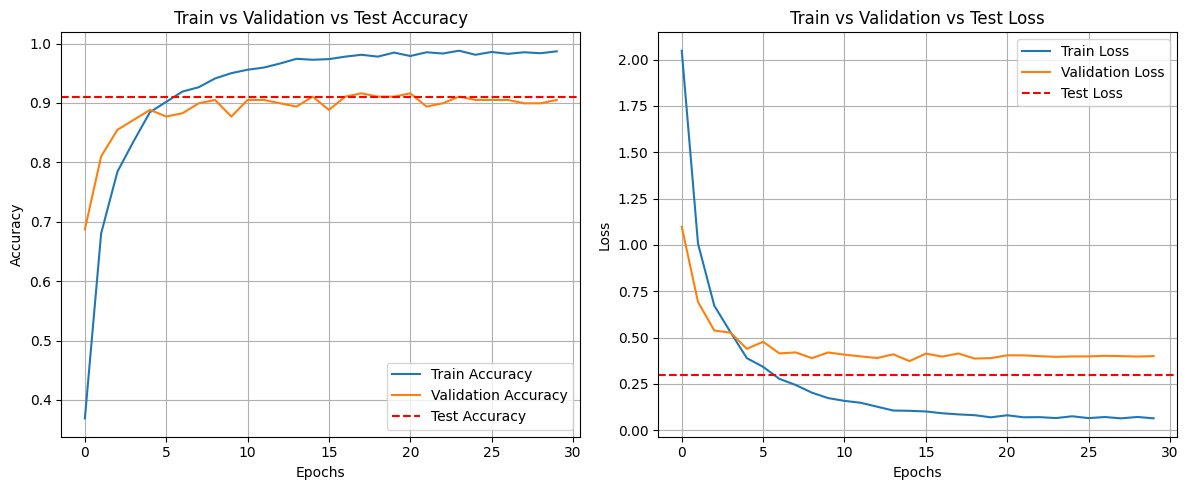

In [25]:
import matplotlib.pyplot as plt

# Ambil test accuracy dan test loss
test_loss, test_accuracy = model_3.evaluate(test_generator)

# Akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='red', linestyle='--', label='Test Accuracy')
plt.title('Train vs Validation vs Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='red', linestyle='--', label='Test Loss')
plt.title('Train vs Validation vs Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [22]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory='/content/dataset/test',  # path ke folder test
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Evaluasi model pada data test
test_loss, test_acc = model_2.evaluate(test_generator, steps=len(test_generator))
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.4f}')


Found 89 images belonging to 18 classes.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9121 - loss: 0.2241
Test loss: 0.2362
Test accuracy: 0.9101


In [27]:
y_pred_probs = model_3.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels dari test generator
y_true = test_generator.classes

# Print classification report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
                    precision    recall  f1-score   support

   01. Ayam Betutu       1.00      1.00      1.00         8
02. Beberuk Terong       1.00      0.75      0.86         4
 03. Coto Makassar       1.00      1.00      1.00         3
         04. Gudeg       1.00      1.00      1.00         5
   05. Kerak Telor       1.00      0.67      0.80         3
      06. Mie Aceh       1.00      1.00      1.00         4
   07. Nasi Kuning       1.00      1.00      1.00         4
    08. Nasi Pecel       1.00      1.00      1.00         7
        09. Papeda       1.00      1.00      1.00         3
        10. Pempek       0.60      0.75      0.67         4
       11. Peuyeum       0.00      0.00      0.00         2
         12. Rawon       1.00      1.00      1.00         5
       13. Rendang       1.00      1.00      1.00         9
   14. Sate Madura       1.00      1.00      1.00         9
        15. Serabi       0.78      1.00      0.88         7
   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Interference

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


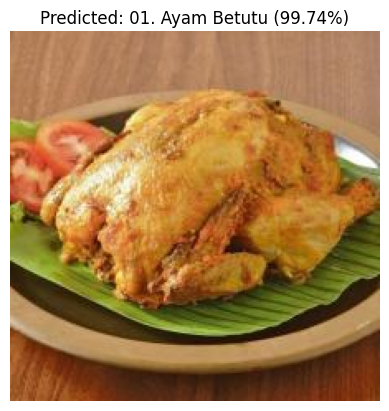

Image: Ayam-Betutu-55_jpg.rf.d882d30ac3b5c6c301e52b9829d468be.jpg
Predicted Label: 01. Ayam Betutu
Confidence: 99.74%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


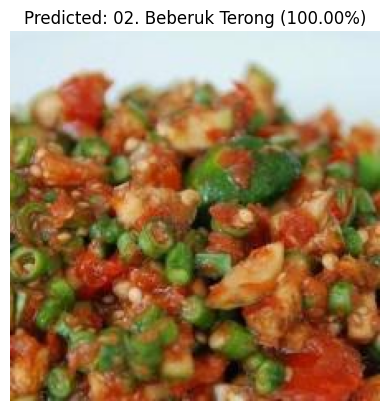

Image: Beberuk-Terong-4_jpg.rf.a22d07a3a8c02d40455a8b31ab910c16.jpg
Predicted Label: 02. Beberuk Terong
Confidence: 100.00%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


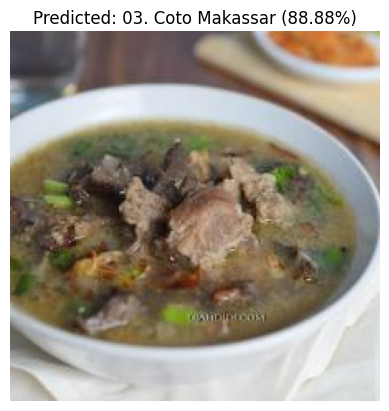

Image: CotoMakassar-47_jpg.rf.5df814b39d1757f213f2bbff9107a20f.jpg
Predicted Label: 03. Coto Makassar
Confidence: 88.88%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


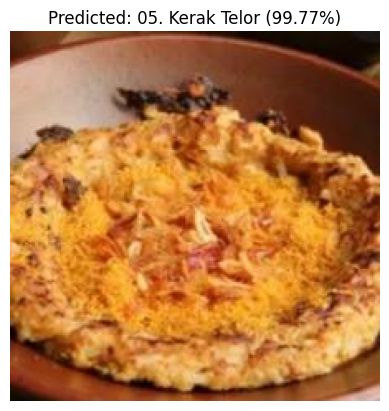

Image: kerak-telor-5_jpg.rf.9eb1a93d5f72923b0321bb5368148676.jpg
Predicted Label: 05. Kerak Telor
Confidence: 99.77%



In [16]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os

# Daftar path gambar
image_paths = [
    '/content/dataset/test/01. Ayam Betutu/Ayam-Betutu-55_jpg.rf.d882d30ac3b5c6c301e52b9829d468be.jpg',
    '/content/dataset/test/02. Beberuk Terong/Beberuk-Terong-4_jpg.rf.a22d07a3a8c02d40455a8b31ab910c16.jpg',
    '/content/dataset/test/03. Coto Makassar/CotoMakassar-47_jpg.rf.5df814b39d1757f213f2bbff9107a20f.jpg',
    '/content/dataset/test/05. Kerak Telor/kerak-telor-5_jpg.rf.9eb1a93d5f72923b0321bb5368148676.jpg'

]

# Ganti ini sesuai dengan label folder pada test_generator
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Loop untuk prediksi tiap gambar
for image_path in image_paths:
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model_3.predict(img_array)
    predicted_index = np.argmax(predictions)
    predicted_label = class_names[predicted_index]
    confidence = np.max(predictions) * 100

    # Tampilkan gambar dan hasil
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

    print(f"Image: {os.path.basename(image_path)}")
    print(f"Predicted Label: {predicted_label}")
    print(f"Confidence: {confidence:.2f}%\n")


# Save Model

In [34]:
#Keras
model_3.save('model_mobilenetv2.keras')

In [33]:
#.pb
model_3.export('saved_model_mobilenetv2')

Saved artifact at 'saved_model_mobilenetv2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_158')
Output Type:
  TensorSpec(shape=(None, 18), dtype=tf.float32, name=None)
Captures:
  135240308145808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135240301992976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135240301996816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135240202083344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135240202080464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135240302001424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135240302000848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135240301995472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135240302000080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135240302000464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13

In [36]:
# TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model_3)
tflite_model = converter.convert()

os.makedirs("tflite", exist_ok=True)
# Menyimpan model TFLite
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

# Jika ada label, simpan label di file label.txt
with open("tflite/label.txt", "w") as f:
    for label in train_generator.class_indices.keys():
        f.write(f"{label}\n")

Saved artifact at '/tmp/tmp6lh3b6gx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_158')
Output Type:
  TensorSpec(shape=(None, 18), dtype=tf.float32, name=None)
Captures:
  135240308145808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135240301992976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135240301996816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135240202083344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135240202080464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135240302001424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135240302000848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135240301995472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135240302000080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135240302000464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135240302